In [1]:
# Enable autoreload to auto-reload modules when edited
%reload_ext autoreload
%autoreload 2

# Standard libraries
import sys
import time
import calendar
import warnings
from datetime import datetime, timedelta, date
from pathlib import Path
import logging

# Data science and ML
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Machine learning
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from xgboost import XGBClassifier
import shap

# BigQuery
import pandas_gbq
from google.cloud import bigquery

# Serialization
import pickle
import cloudpickle


# Pandas display options for large DataFrames
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Suppress warnings
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)

# Initialize BigQuery client once
client = bigquery.Client()
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

from sklearn.utils import resample

## Prepare Data

1. Merge specified range of snapshots
2. Split into train and test data (StratifiedShuffleSplit)

In [2]:
import pandas as pd
from pathlib import Path

# Optionally, skip using raw_data_file_path since we won't save it
date_ranges = [
    'digigold_feature_2025-08-01',
    'digigold_feature_2025-05-01',
    'digigold_feature_2025-06-01'
]

data = pd.DataFrame()
summary_list = []

for date in date_ranges:
    file_path = f'Revisedsnapshots/{date}.csv'
    new_df = pd.read_csv(file_path)
    print(f"Loaded {file_path}, shape: {new_df.shape}")

    # Calculate conversion metrics
    total = len(new_df)
    conversions = new_df['on_us_target'].sum() 
    conv_rate = (conversions / total * 100) if total > 0 else 0

    summary_list.append({
        'snapshot': date,
        'total_records': total,
        'total_conversions': conversions,
        'conversion_rate_%': round(conv_rate, 2)
    })

    # Append data
    data = pd.concat([data, new_df], ignore_index=True)

# Show summary
summary_df = pd.DataFrame(summary_list)
print("\n📊 Conversion summary per snapshot:")
print(summary_df)

print(f"\nFinal combined shape: {data.shape}")

Loaded Revisedsnapshots/digigold_feature_2025-08-01.csv, shape: (6641558, 199)
Loaded Revisedsnapshots/digigold_feature_2025-05-01.csv, shape: (5528261, 199)
Loaded Revisedsnapshots/digigold_feature_2025-06-01.csv, shape: (5868667, 199)

📊 Conversion summary per snapshot:
                      snapshot  total_records  total_conversions  \
0  digigold_feature_2025-08-01        6641558               1829   
1  digigold_feature_2025-05-01        5528261               1624   
2  digigold_feature_2025-06-01        5868667               1366   

   conversion_rate_%  
0               0.03  
1               0.03  
2               0.02  

Final combined shape: (18038486, 199)


In [3]:
data.on_us_target.value_counts()

on_us_target
0    18033667
1        4819
Name: count, dtype: int64

In [4]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18038486 entries, 0 to 18038485
Columns: 199 entries, mobilenumber to EXPERIAN_Score_V3
dtypes: float64(178), int64(3), object(18)
memory usage: 38.9 GB


In [5]:
data.head()

,mobilenumber,customer_id,createddate,on_us_target,total_investment_app,transactions,IsGymLover,IsSingle,IsParent,insuranceservices,PLApps,DigiGoldApps,UPIApps,investmentsapps,InsuranceApps,HouseHoldSize,IsTechie,IsCarOwner,IsTraveler,IsUsingDigitalPayment,snapshot_partition,fixed_deposit_1m,fixed_deposit_3m,fixed_deposit_6m,fixed_deposit_12m,recurring_deposit_1m,recurring_deposit_3m,recurring_deposit_6m,recurring_deposit_12m,term_deposit_1m,term_deposit_3m,term_deposit_6m,term_deposit_12m,provident_fund_1m,provident_fund_3m,provident_fund_6m,provident_fund_12m,nps_1m,nps_3m,nps_6m,nps_12m,mutual_fund_1m,mutual_fund_3m,mutual_fund_6m,mutual_fund_12m,trading_1m,trading_3m,trading_6m,trading_12m,fixed_deposit_1m_3m_ratio,fixed_deposit_3m_6m_ratio,fixed_deposit_6m_12m_ratio,fixed_deposit_3m_12m_ratio,recurring_deposit_1m_3m_ratio,recurring_deposit_3m_6m_ratio,recurring_deposit_6m_12m_ratio,recurring_deposit_3m_12m_ratio,term_deposit_1m_3m_ratio,term_deposit_3m_6m_ratio,term_deposit_6m_12m_ratio,term_deposit_3m_12m_ratio,provident_fund_1m_3m_ratio,provident_fund_3m_6m_ratio,provident_fund_6m_12m_ratio,provident_fund_3m_12m_ratio,nps_1m_3m_ratio,nps_3m_6m_ratio,nps_6m_12m_ratio,nps_3m_12m_ratio,mutual_fund_1m_3m_ratio,mutual_fund_3m_6m_ratio,mutual_fund_6m_12m_ratio,mutual_fund_3m_12m_ratio,trading_1m_3m_ratio,trading_3m_6m_ratio,trading_6m_12m_ratio,trading_3m_12m_ratio,fixed_deposit_1m_scaled,recurring_deposit_1m_scaled,term_deposit_1m_scaled,provident_fund_1m_scaled,nps_1m_scaled,mutual_fund_1m_scaled,trading_1m_scaled,fixed_deposit_3m_scaled,recurring_deposit_3m_scaled,term_deposit_3m_scaled,provident_fund_3m_scaled,nps_3m_scaled,mutual_fund_3m_scaled,trading_3m_scaled,fixed_deposit_6m_scaled,recurring_deposit_6m_scaled,term_deposit_6m_scaled,provident_fund_6m_scaled,nps_6m_scaled,mutual_fund_6m_scaled,trading_6m_scaled,fixed_deposit_12m_scaled,recurring_deposit_12m_scaled,term_deposit_12m_scaled,provident_fund_12m_scaled,nps_12m_scaled,mutual_fund_12m_scaled,trading_12m_scaled,salary_1m,salary_3m,salary_6m,salary_12m,amt_insurance_spend_1m,amt_investment_spend_1m,amt_medical_spend_1m,amt_bills_utilities_spend_1m,amt_shopping_purchase_spend_1m,amt_online_shopping_spend_1m,amt_entertainment_spend_1m,amt_groceries_spend_1m,amt_education_spend_1m,amt_travel_spend_1m,amt_emi_repayment_spend_1m,amt_housing_services_spend_1m,amt_vehicle_expenses_spend_1m,amt_insurance_spend_3m,amt_investment_spend_3m,amt_medical_spend_3m,amt_bills_utilities_spend_3m,amt_shopping_purchase_spend_3m,amt_online_shopping_spend_3m,amt_entertainment_spend_3m,amt_groceries_spend_3m,amt_education_spend_3m,amt_travel_spend_3m,amt_emi_repayment_spend_3m,amt_housing_services_spend_3m,amt_vehicle_expenses_spend_3m,amt_insurance_spend_6m,amt_investment_spend_6m,amt_medical_spend_6m,amt_bills_utilities_spend_6m,amt_shopping_purchase_spend_6m,amt_online_shopping_spend_6m,amt_entertainment_spend_6m,amt_groceries_spend_6m,amt_education_spend_6m,amt_travel_spend_6m,amt_emi_repayment_spend_6m,amt_housing_services_spend_6m,amt_vehicle_expenses_spend_6m,amt_insurance_spend_12m,amt_investment_spend_12m,amt_medical_spend_12m,amt_bills_utilities_spend_12m,amt_shopping_purchase_spend_12m,amt_online_shopping_spend_12m,amt_entertainment_spend_12m,amt_groceries_spend_12m,amt_education_spend_12m,amt_travel_spend_12m,amt_emi_repayment_spend_12m,amt_housing_services_spend_12m,amt_vehicle_expenses_spend_12m,cc_due_1m,cc_due_3m,cc_due_6m,cc_due_12m,inflow_1m,inflow_3m,inflow_6m,inflow_12m,expense_1m,expense_3m,expense_6m,expense_12m,occupation,bureau_income,gender,age_in_years,pl_enq_count_3m,pl_enq_amt_3m,pl_enq_count_6m,pl_enq_amt_6m,hfl_enq_count_3m,hfl_enq_amt_3m,hfl_enq_count_6m,hfl_enq_amt_6m,bl_enq_count_3m,bl_enq_amt_3m,bl_enq_count_6m,bl_enq_amt_6m,cc_enq_count_3m,cc_enq_amt_3m,cc_enq_count_6m,cc_enq_amt_6m,pl_loan_closed_12m,hfl_loan_closed_12m,business_loan_closed_12m,pl_loan_open_count_12m,Tier,EXPERIAN_Score_V3
0,7297847904,1998702,2024-09-11 21:16:29.405506,0,0.0,0.0,Na

In [6]:
data.customer_id.nunique(),data.shape[0]

(6618243, 18038486)

# removing those features from dataset who has fill rate less than 15%

In [7]:
feature_less_impt = ['createddate','pl_enq_count_3m',
 'pl_enq_amt_3m',
 'pl_enq_count_6m',
 'pl_enq_amt_6m',
 'provident_fund_6m_12m_ratio',
 'provident_fund_3m_12m_ratio',
 'salary_12m',
 'salary_6m',
 'provident_fund_3m_6m_ratio',
 'salary_3m',
 'mutual_fund_3m_12m_ratio',
 'mutual_fund_6m_12m_ratio',
 'provident_fund_1m_3m_ratio',
 'mutual_fund_3m_6m_ratio',
 'cc_enq_count_3m',
 'cc_enq_count_6m',
 'cc_enq_amt_3m',
 'cc_enq_amt_6m',
 'mutual_fund_1m_3m_ratio',
 'salary_1m',
 'fixed_deposit_6m_12m_ratio',
 'fixed_deposit_3m_12m_ratio',
 'recurring_deposit_3m_12m_ratio',
 'recurring_deposit_6m_12m_ratio',
 'fixed_deposit_3m_6m_ratio',
 'bl_enq_count_6m',
 'bl_enq_amt_3m',
 'bl_enq_amt_6m',
 'bl_enq_count_3m',
 'hfl_enq_amt_6m',
 'hfl_enq_count_3m',
 'hfl_enq_amt_3m',
 'hfl_enq_count_6m',
 'fixed_deposit_1m_3m_ratio',
 'term_deposit_6m_12m_ratio',
 'term_deposit_3m_12m_ratio',
 'recurring_deposit_3m_6m_ratio',
 'trading_6m_12m_ratio',
 'trading_3m_12m_ratio',
 'term_deposit_3m_6m_ratio',
 'trading_3m_6m_ratio',
 'term_deposit_1m_3m_ratio',
 'trading_1m_3m_ratio',
 'recurring_deposit_1m_3m_ratio',
 'nps_6m_12m_ratio',
 'nps_3m_12m_ratio',
 'nps_3m_6m_ratio',
 'nps_1m_3m_ratio',
'fixed_deposit_1m_scaled',
 'recurring_deposit_1m_scaled',
 'term_deposit_1m_scaled',
 'provident_fund_1m_scaled',
 'nps_1m_scaled',
 'mutual_fund_1m_scaled',
 'trading_1m_scaled',
 'fixed_deposit_3m_scaled',
 'recurring_deposit_3m_scaled',
 'term_deposit_3m_scaled',
 'provident_fund_3m_scaled',
 'nps_3m_scaled',
 'mutual_fund_3m_scaled',
 'trading_3m_scaled',
 'fixed_deposit_6m_scaled',
 'recurring_deposit_6m_scaled',
 'term_deposit_6m_scaled',
 'provident_fund_6m_scaled',
 'nps_6m_scaled',
 'mutual_fund_6m_scaled',
 'trading_6m_scaled',
 'fixed_deposit_12m_scaled',
 'recurring_deposit_12m_scaled',
 'term_deposit_12m_scaled',
 'provident_fund_12m_scaled',
 'nps_12m_scaled',
 'mutual_fund_12m_scaled',
 'trading_12m_scaled']


data.drop(feature_less_impt,axis=1,inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18038486 entries, 0 to 18038485
Columns: 122 entries, mobilenumber to EXPERIAN_Score_V3
dtypes: float64(102), int64(3), object(17)
memory usage: 16.4+ GB


In [9]:
data.columns.to_list()

['mobilenumber',
 'customer_id',
 'on_us_target',
 'total_investment_app',
 'transactions',
 'IsGymLover',
 'IsSingle',
 'IsParent',
 'insuranceservices',
 'PLApps',
 'DigiGoldApps',
 'UPIApps',
 'investmentsapps',
 'InsuranceApps',
 'HouseHoldSize',
 'IsTechie',
 'IsCarOwner',
 'IsTraveler',
 'IsUsingDigitalPayment',
 'snapshot_partition',
 'fixed_deposit_1m',
 'fixed_deposit_3m',
 'fixed_deposit_6m',
 'fixed_deposit_12m',
 'recurring_deposit_1m',
 'recurring_deposit_3m',
 'recurring_deposit_6m',
 'recurring_deposit_12m',
 'term_deposit_1m',
 'term_deposit_3m',
 'term_deposit_6m',
 'term_deposit_12m',
 'provident_fund_1m',
 'provident_fund_3m',
 'provident_fund_6m',
 'provident_fund_12m',
 'nps_1m',
 'nps_3m',
 'nps_6m',
 'nps_12m',
 'mutual_fund_1m',
 'mutual_fund_3m',
 'mutual_fund_6m',
 'mutual_fund_12m',
 'trading_1m',
 'trading_3m',
 'trading_6m',
 'trading_12m',
 'amt_insurance_spend_1m',
 'amt_investment_spend_1m',
 'amt_medical_spend_1m',
 'amt_bills_utilities_spend_1m',
 'amt

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18038486 entries, 0 to 18038485
Columns: 122 entries, mobilenumber to EXPERIAN_Score_V3
dtypes: float64(102), int64(3), object(17)
memory usage: 16.4+ GB


In [12]:
data.insuranceservices.value_counts()

insuranceservices
Phonepe                                                                                                982276
Phonepe,                                                                                               731738
Navi,Phonepe                                                                                           437264
Navi,Phonepe,                                                                                          234612
CRED,Phonepe                                                                                           179602
                                                                                                        ...  
Acko Insurance,Navi,HDFC Life Insurance App,Star Health,Phonepe,HDFC ERGO Insurance                         1
HDFC ERGO Insurance,ICICI Prudential Life,HDFC Life Insurance App,Phonepe,ILTakeCare Insurance App,         1
Star Health,Phonepe,PolicyBazaar,TATA AIA life insurance,HDFC ERGO Insurance,Tata Neu                 

In [13]:
data.drop('insuranceservices',axis=1,inplace=True)

In [17]:
data['snapshot_partition'] = pd.to_datetime(data['snapshot_partition'])

In [18]:
data.select_dtypes("object").columns.to_list()

['IsGymLover',
 'IsSingle',
 'IsParent',
 'PLApps',
 'DigiGoldApps',
 'UPIApps',
 'investmentsapps',
 'InsuranceApps',
 'IsTechie',
 'IsCarOwner',
 'IsTraveler',
 'IsUsingDigitalPayment',
 'occupation',
 'gender',
 'Tier']

In [19]:
data.select_dtypes("number").columns.to_list()

['mobilenumber',
 'customer_id',
 'on_us_target',
 'total_investment_app',
 'transactions',
 'HouseHoldSize',
 'fixed_deposit_1m',
 'fixed_deposit_3m',
 'fixed_deposit_6m',
 'fixed_deposit_12m',
 'recurring_deposit_1m',
 'recurring_deposit_3m',
 'recurring_deposit_6m',
 'recurring_deposit_12m',
 'term_deposit_1m',
 'term_deposit_3m',
 'term_deposit_6m',
 'term_deposit_12m',
 'provident_fund_1m',
 'provident_fund_3m',
 'provident_fund_6m',
 'provident_fund_12m',
 'nps_1m',
 'nps_3m',
 'nps_6m',
 'nps_12m',
 'mutual_fund_1m',
 'mutual_fund_3m',
 'mutual_fund_6m',
 'mutual_fund_12m',
 'trading_1m',
 'trading_3m',
 'trading_6m',
 'trading_12m',
 'amt_insurance_spend_1m',
 'amt_investment_spend_1m',
 'amt_medical_spend_1m',
 'amt_bills_utilities_spend_1m',
 'amt_shopping_purchase_spend_1m',
 'amt_online_shopping_spend_1m',
 'amt_entertainment_spend_1m',
 'amt_groceries_spend_1m',
 'amt_education_spend_1m',
 'amt_travel_spend_1m',
 'amt_emi_repayment_spend_1m',
 'amt_housing_services_spend_1

In [20]:
round(data['on_us_target'].sum() * 100/ data.shape[0], 2)

0.03

In [21]:
cat_col = data.select_dtypes("object").columns.to_list()
cat_col

['IsGymLover',
 'IsSingle',
 'IsParent',
 'PLApps',
 'DigiGoldApps',
 'UPIApps',
 'investmentsapps',
 'InsuranceApps',
 'IsTechie',
 'IsCarOwner',
 'IsTraveler',
 'IsUsingDigitalPayment',
 'occupation',
 'gender',
 'Tier']

In [22]:
num_col = data.select_dtypes("number").columns.to_list()
num_col

['mobilenumber',
 'customer_id',
 'on_us_target',
 'total_investment_app',
 'transactions',
 'HouseHoldSize',
 'fixed_deposit_1m',
 'fixed_deposit_3m',
 'fixed_deposit_6m',
 'fixed_deposit_12m',
 'recurring_deposit_1m',
 'recurring_deposit_3m',
 'recurring_deposit_6m',
 'recurring_deposit_12m',
 'term_deposit_1m',
 'term_deposit_3m',
 'term_deposit_6m',
 'term_deposit_12m',
 'provident_fund_1m',
 'provident_fund_3m',
 'provident_fund_6m',
 'provident_fund_12m',
 'nps_1m',
 'nps_3m',
 'nps_6m',
 'nps_12m',
 'mutual_fund_1m',
 'mutual_fund_3m',
 'mutual_fund_6m',
 'mutual_fund_12m',
 'trading_1m',
 'trading_3m',
 'trading_6m',
 'trading_12m',
 'amt_insurance_spend_1m',
 'amt_investment_spend_1m',
 'amt_medical_spend_1m',
 'amt_bills_utilities_spend_1m',
 'amt_shopping_purchase_spend_1m',
 'amt_online_shopping_spend_1m',
 'amt_entertainment_spend_1m',
 'amt_groceries_spend_1m',
 'amt_education_spend_1m',
 'amt_travel_spend_1m',
 'amt_emi_repayment_spend_1m',
 'amt_housing_services_spend_1

In [23]:
from matplotlib import pyplot
import seaborn as sb

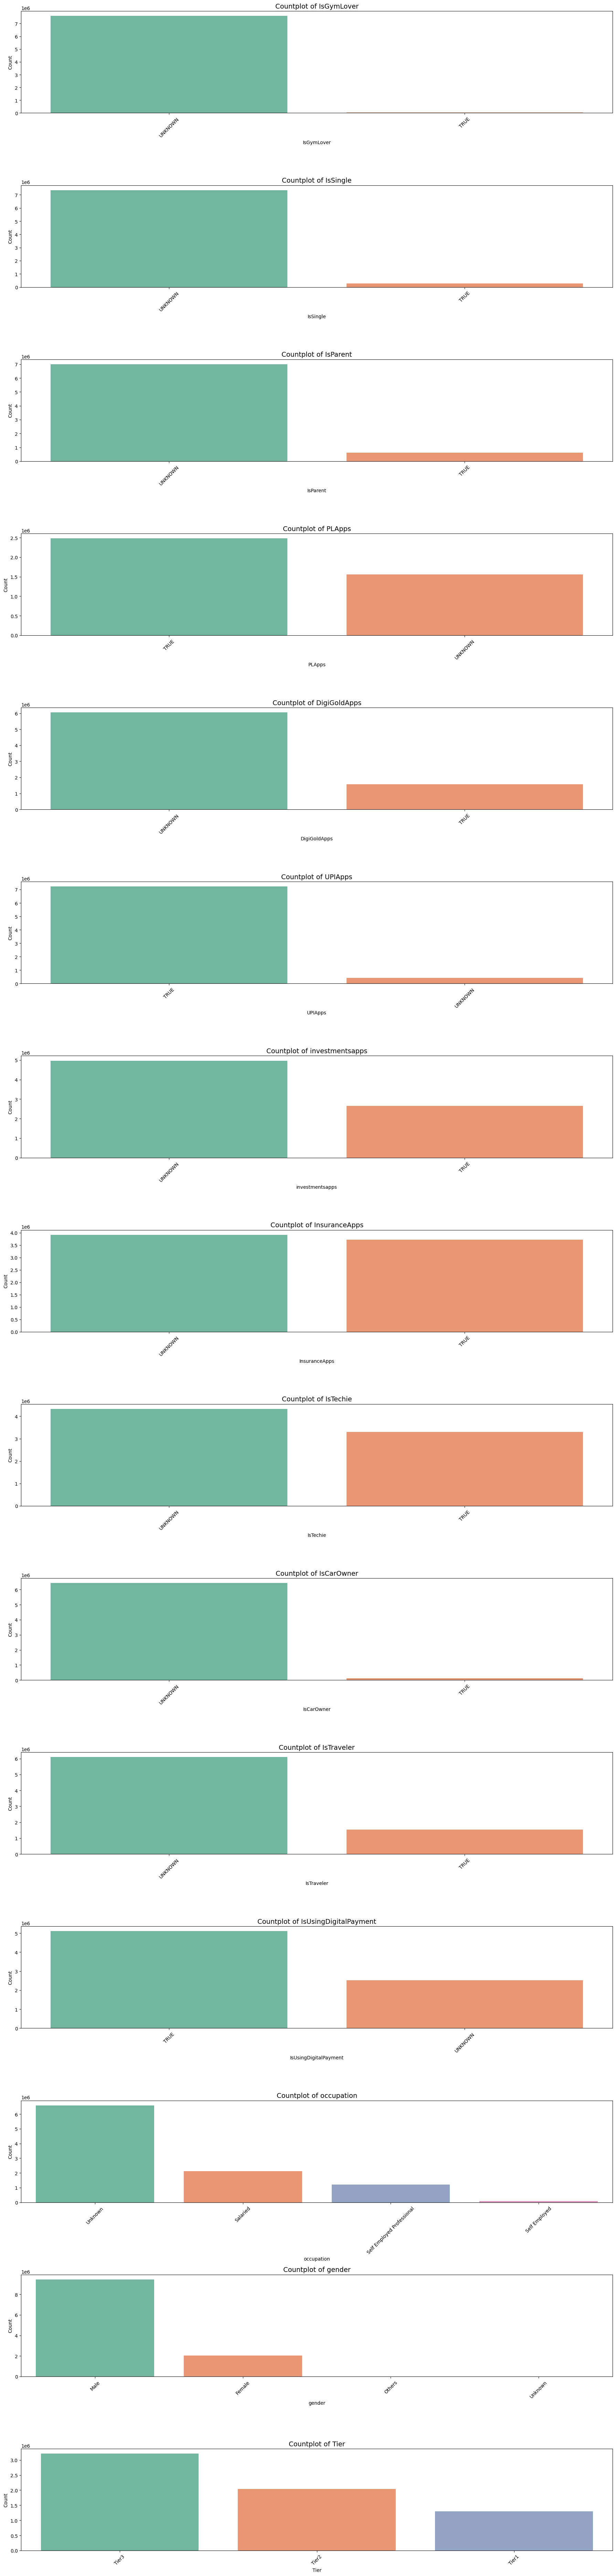

In [24]:
plt.figure(figsize=(18, 5 * len(cat_col)))

for i, col in enumerate(cat_col, 1):
    plt.subplot(len(cat_col), 1, i)
    sns.countplot(data=data, x=col, palette='Set2', order=data[col].value_counts().index)
    plt.title(f'Countplot of {col}', fontsize=14)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

In [26]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18038486 entries, 0 to 18038485
Columns: 121 entries, mobilenumber to EXPERIAN_Score_V3
dtypes: datetime64[ns](1), float64(102), int64(3), object(15)
memory usage: 25.6 GB


# selecting input and output

In [27]:
x = data.drop(columns=['on_us_target', 'customer_id', 'mobilenumber','snapshot_partition'])
y = data['on_us_target']

In [28]:
x.shape,y.shape

((18038486, 117), (18038486,))

In [29]:
# Taking Sample 10 lakh records stratified (to speed up tuning)
x_sample, y_sample = resample(x, y, n_samples=1_000_000, stratify=y, random_state=42)
x_sample.shape, y_sample.shape

((1000000, 117), (1000000,))

In [30]:
data['on_us_target'].value_counts(dropna=False)

on_us_target
0    18033667
1        4819
Name: count, dtype: int64

In [31]:
y_sample.value_counts(dropna=False)

on_us_target
0    999733
1       267
Name: count, dtype: int64

# handling imbalance data

In [32]:
from collections import Counter
counter = Counter(y_sample)
counter

Counter({0: 999733, 1: 267})

In [33]:
scale_pos_weight = counter[0] / counter[1]
scale_pos_weight

3744.318352059925

In [34]:
x_sample.head()

,total_investment_app,transactions,IsGymLover,IsSingle,IsParent,PLApps,DigiGoldApps,UPIApps,investmentsapps,InsuranceApps,HouseHoldSize,IsTechie,IsCarOwner,IsTraveler,IsUsingDigitalPayment,fixed_deposit_1m,fixed_deposit_3m,fixed_deposit_6m,fixed_deposit_12m,recurring_deposit_1m,recurring_deposit_3m,recurring_deposit_6m,recurring_deposit_12m,term_deposit_1m,term_deposit_3m,term_deposit_6m,term_deposit_12m,provident_fund_1m,provident_fund_3m,provident_fund_6m,provident_fund_12m,nps_1m,nps_3m,nps_6m,nps_12m,mutual_fund_1m,mutual_fund_3m,mutual_fund_6m,mutual_fund_12m,trading_1m,trading_3m,trading_6m,trading_12m,amt_insurance_spend_1m,amt_investment_spend_1m,amt_medical_spend_1m,amt_bills_utilities_spend_1m,amt_shopping_purchase_spend_1m,amt_online_shopping_spend_1m,amt_entertainment_spend_1m,amt_groceries_spend_1m,amt_education_spend_1m,amt_travel_spend_1m,amt_emi_repayment_spend_1m,amt_housing_services_spend_1m,amt_vehicle_expenses_spend_1m,amt_insurance_spend_3m,amt_investment_spend_3m,amt_medical_spend_3m,amt_bills_utilities_spend_3m,amt_shopping_purchase_spend_3m,amt_online_shopping_spend_3m,amt_entertainment_spend_3m,amt_groceries_spend_3m,amt_education_spend_3m,amt_travel_spend_3m,amt_emi_repayment_spend_3m,amt_housing_services_spend_3m,amt_vehicle_expenses_spend_3m,amt_insurance_spend_6m,amt_investment_spend_6m,amt_medical_spend_6m,amt_bills_utilities_spend_6m,amt_shopping_purchase_spend_6m,amt_online_shopping_spend_6m,amt_entertainment_spend_6m,amt_groceries_spend_6m,amt_education_spend_6m,amt_travel_spend_6m,amt_emi_repayment_spend_6m,amt_housing_services_spend_6m,amt_vehicle_expenses_spend_6m,amt_insurance_spend_12m,amt_investment_spend_12m,amt_medical_spend_12m,amt_bills_utilities_spend_12m,amt_shopping_purchase_spend_12m,amt_online_shopping_spend_12m,amt_entertainment_spend_12m,amt_groceries_spend_12m,amt_education_spend_12m,amt_travel_spend_12m,amt_emi_repayment_spend_12m,amt_housing_services_spend_12m,amt_vehicle_expenses_spend_12m,cc_due_1m,cc_due_3m,cc_due_6m,cc_due_12m,inflow_1m,inflow_3m,inflow_6m,inflow_12m,expense_1m,expense_3m,expense_6m,expense_12m,occupation,bureau_income,gender,age_in_years,pl_loan_closed_12m,hfl_loan_closed_12m,business_loan_closed_12m,pl_loan_open_count_12m,Tier,EXPERIAN_Score_V3
5074636,0.0,0.0,UNKNOWN,UNKNOWN,UNKNOWN,NaN,UNKNOWN,TRUE,UNKNOWN,TRUE,0.0,UNKNOWN,UNKNOWN,UNKNOWN,TRUE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0,0.0,95.00,375.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,129521.0,273508.00,0.0,0.0,70436.0,349680.94,Salaried,90000.0,Male,42.0,6.0,0.0,0.0,8.0,Tier2,733.0
13707621,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2712114,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8000.0,2075.52,649.0,16973.78,25815.81,0.0,7437.0,0.0,2285.6,37184.0,0.0,9600.0,0.0,0.0,0.0,63737.0,0.0,0.0,0.0,234098.87,0.0,0.0,0.0,452171.14,Unknown,NaN,Male,36.0,0.0,0.0,0.0,0.0,NaN,809.0
1461017,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [36]:
for col in cat_col:
    if col in x_sample.columns:
        x_sample[col] = x_sample[col].astype('category')

In [37]:
x_sample.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 5074636 to 9664143
Columns: 117 entries, total_investment_app to EXPERIAN_Score_V3
dtypes: category(15), float64(102)
memory usage: 800.1 MB


In [38]:
from xgboost import callback
callback.EarlyStopping(rounds=50)

In [39]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score
from xgboost import XGBClassifier, callback
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from optuna.integration.xgboost import XGBoostPruningCallback

# doing tuning

In [49]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
import numpy as np
from xgboost import XGBClassifier

def objective(trial):
    try:
        # Define hyperparameters
        clf = XGBClassifier(
            n_estimators=trial.suggest_int('n_estimators', 100, 500, step=25),
            max_depth=trial.suggest_int('max_depth', 3, 15),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
            gamma=trial.suggest_float('gamma', 0, 5),
            subsample=trial.suggest_float('subsample', 0.5, 1.0),
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1.0),
            # reg_alpha=trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            # reg_lambda=trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            scale_pos_weight=scale_pos_weight,  # imbalance handling
            use_label_encoder=False,
            enable_categorical=True,              # categorical support
            tree_method='hist',                   # faster on large datasets
            objective='binary:logistic',
            eval_metric='logloss',
            n_jobs=-1,
            verbosity=0
        )

        # Cross-validation
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        auc_scores = cross_val_score(
            clf, x_sample, y_sample,
            cv=skf,
            scoring=make_scorer(roc_auc_score, needs_proba=True)
        )

        # Mean AUC
        mean_auc = np.mean(auc_scores)

        # In case of NaN (e.g., only one class in a fold)
        if np.isnan(mean_auc):
            print("⚠️ Mean AUC is NaN, returning 0.0")
            return 0.0

        return mean_auc

    except Exception as e:
        print(f"❌ Trial failed: {e}")
        return 0.0  # or float('nan'), but 0.0 ensures Optuna records it safely


In [50]:
# ✅ Early stopping callback: stop if no improvement in last N trials
class EarlyStopCallback:
    def __init__(self, early_stop_rounds=10):
        self.early_stop_rounds = early_stop_rounds
        self.best_score = None
        self.no_improvement_trials = 0

    def __call__(self, study, trial):
        if self.best_score is None or study.best_value > self.best_score:
            self.best_score = study.best_value
            self.no_improvement_trials = 0
        else:
            self.no_improvement_trials += 1

        if self.no_improvement_trials >= self.early_stop_rounds:
            print(f"\n[EarlyStopCallback] No improvement in {self.early_stop_rounds} trials. Stopping study.")
            study.stop()

# create study object

In [ ]:
import optuna
#creating study object and iterating them
pruner = optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=5) 

#MedianPruner is an early stopping strategy in Optuna that automatically stops poorly performing trials.
study = optuna.create_study(direction="maximize", pruner=pruner)

# ✅ Run optimization with early stopping
early_stop = EarlyStopCallback(early_stop_rounds=10)
study.optimize(objective, n_trials=50, show_progress_bar=True, callbacks=[early_stop])

[I 2025-10-08 12:31:39,755] A new study created in memory with name: no-name-54804b68-4b9c-444a-a408-ce1f77c0ff57


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-08 12:35:45,919] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 425, 'max_depth': 12, 'learning_rate': 0.22785231894826036, 'gamma': 3.632381185551898, 'subsample': 0.6628025141903204, 'colsample_bytree': 0.8962805310669126}. Best is trial 0 with value: 1.0.
[I 2025-10-08 12:40:44,746] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 425, 'max_depth': 3, 'learning_rate': 0.05252737379951002, 'gamma': 3.7352270528700435, 'subsample': 0.5652813422421439, 'colsample_bytree': 0.6666670938587544}. Best is trial 0 with value: 1.0.
[I 2025-10-08 12:43:52,501] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 300, 'max_depth': 11, 'learning_rate': 0.20467194451854956, 'gamma': 4.326925469020183, 'subsample': 0.6615073539921861, 'colsample_bytree': 0.8445716898514046}. Best is trial 0 with value: 1.0.
[I 2025-10-08 12:48:53,771] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 400, 'max_depth': 15, 'learning_rate': 

In [ ]:
print("Best trial:")
print("  Value (ROC-AUC):", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

In [ ]:
import optuna.visualization as vis

#Tracks how the AUC score improved over time.
vis.plot_optimization_history(study).show()

In [ ]:
#shows how combinations of parameters affect the objective.
vis.plot_parallel_coordinate(study).show()

In [ ]:
#Effect of a single hyperparameter across trials.
vis.plot_slice(study).show()

In [ ]:
#we can do Visualize interaction between any 2 hyperparameters.
vis.plot_contour(study, params=['learning_rate', 'max_depth']).show()